In [2]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down
import matplotlib.pyplot as plt

import warnings

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

In [3]:
tmpa_dir = os.path.join('..', 'data', 'tmpa_conus_data')
inputfile = os.path.join(tmpa_dir, 'data_tmpa_3h_cut_upscale.nc')

In [4]:
print(f'Read data to {inputfile}')
# ncf = xr.open_dataset(inputfile, engine="h5netcdf",phony_dims='sort') # FOR HDF5
ncf = xr.open_dataset(inputfile)

tmpalat = ncf['lat'][:].values
tmpalon = ncf['lon'][:].values
dates = ncf['time'][:].values
dset = ncf['PRE'].values

print(f'Precipitation data shape: {dset.shape}')

del ncf

Read data to ../data/tmpa_conus_data/data_tmpa_3h_cut_upscale.nc
Precipitation data shape: (2433, 12, 20)


In [5]:
dset = np.swapaxes(dset,0,2)

In [6]:
clat = 34.875
clon = -98.125

dx = 0.5
dy = 0.5

clat = tmpalat[0]
clon = tmpalon[0] + 4*dx

In [7]:
npix = 3
buffer = 0.50*npix*dx
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer

x = da.from_array(dset, chunks=(6, 6, 300))

xrs0 = xr.DataArray(x,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates}, dims=('lon', 'lat', 'time'))

# set negative values to NaN (missing values)
xrs = xrs0.where(xrs0 >= -0.001)
nlon = xrs.shape[0]
nlat = xrs.shape[1]
ntime = xrs.shape[2]

solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

# XARRAY WITH VALUES LOADED IN MEMORY
box_3h = xrs.where(bcond, drop = True).load()
print(box_3h.shape)

(1, 1, 2433)


In [7]:
lon2d, lat2d = np.meshgrid(xrs0['lon'], xrs0['lat'])
lon2d_box, lat2d_box = np.meshgrid(box_3h['lon'], box_3h['lat'])

/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


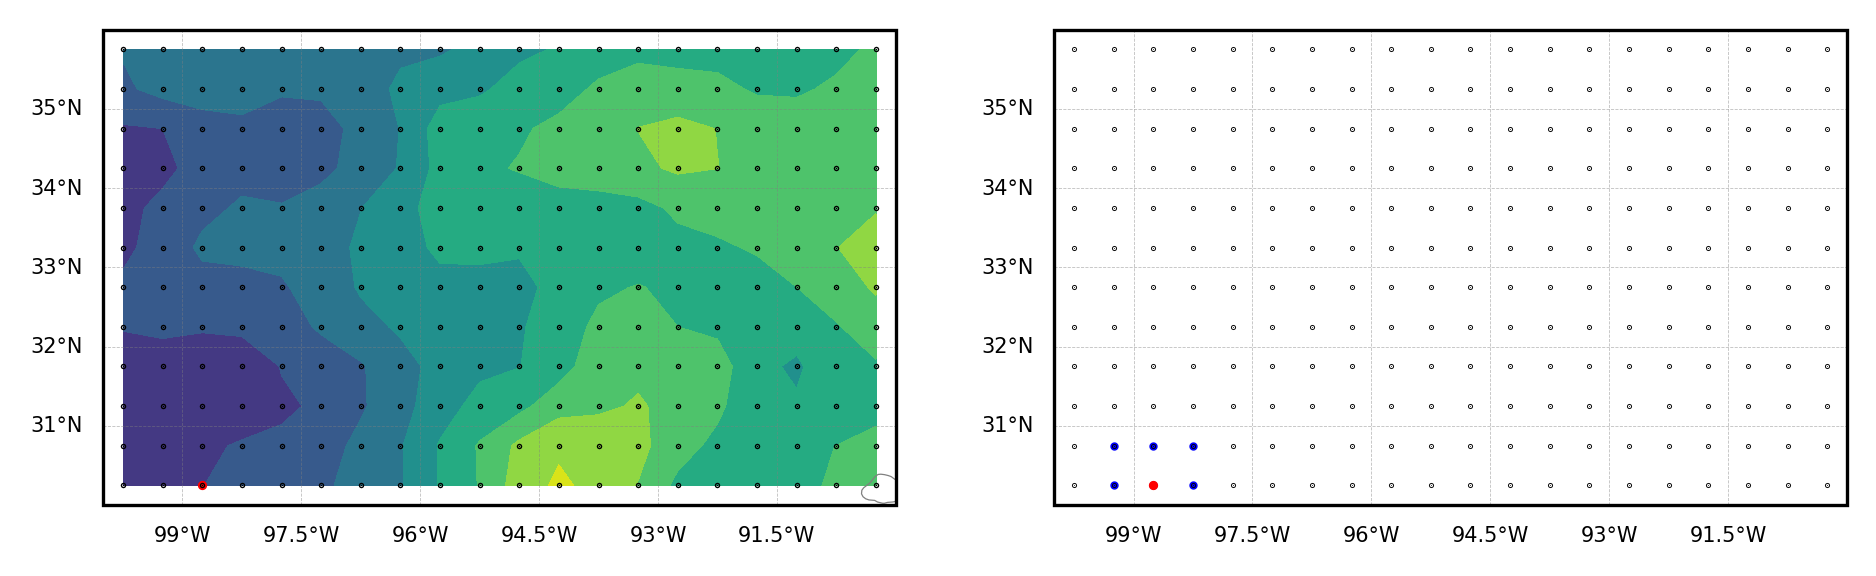

In [8]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(7.5,5),dpi=300)
gs = gridspec.GridSpec(1,2)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
ax1.set_extent([-100, -90, 30, 36], crs=proj)
ax1.contourf(lon2d, lat2d, np.mean(xrs,axis=2).T)
ax1.scatter(clon, clat, s=1.5, color='r')
ax1.scatter(lon2d, lat2d ,s=0.1, color='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

# =======================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([-100, -90, 30, 36], crs=proj)
ax1.scatter(clon, clat, s=1.5, color='r', zorder=10)
# ax1.scatter(box_3h['lon'], box_3h['lat'], s=1, color='b')
ax1.scatter(lon2d_box, lat2d_box,s=1, color='b')
ax1.scatter(lon2d, lat2d ,s=0.05, color='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

In [9]:
DOWN_PAR = np.zeros([ntime, 2*nlat-1, 2*nlon-1])

In [10]:
Tr = 50 # return time
Tr = np.array([10, 20, 30, 50, 80, 100]) # pass

print('Example: running the downscaling function')
init_time = time.time()
downres = down.downscale(box_3h, Tr, thresh=1.0, L0=0.0001, toll=0.005,
                            acf='mar', save_yearly=True,
                            maxmiss=300, clat=clat, clon=clon,
                            opt_method='genetic', plot=True)#maxmiss=36
end_time = time.time()
exec_time = end_time - init_time
print('Downscaling, execution time was = {} minutes'.format(exec_time/60))

Example: running the downscaling function
downscale warning: box sizes are not equal
Downscaling Intermittency


/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will b

Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.0014646856398282395
differential_evolution step 2: f(x)= 0.0014566990548835566
differential_evolution step 3: f(x)= 0.0014566990548835566
differential_evolution step 4: f(x)= 0.0014566990548835566
differential_evolution step 5: f(x)= 0.0014204493321573195
Polishing solution with 'L-BFGS-B'
integration domain is zero
Downscaling pdf - global Weibull parameters
[59.]
[11.72134053]
[0.79032447]
Downscaling pdf - yearly Weibull parameters
[50.]
[11.71091628]
[0.78936986]
Downscaling, execution time was = 2.2639910856882732 minutes


In [11]:
downres

{'NYs': array([55.]),
 'CYs': array([10.8620981]),
 'WYs': array([0.81947286]),
 'NYd': array([50.]),
 'CYd': array([11.71091628]),
 'WYd': array([0.78936986]),
 'Tr': array([ 10,  20,  30,  50,  80, 100]),
 'mev_d': array([118.26421094, 135.86341067, 146.21950525, 159.38868052,
        171.65005838, 177.52389374]),
 'mev_s': array([102.82563194, 117.28277891, 125.75456414, 136.49366998,
        146.46118087, 151.22616743]),
 'gam_d': 0.8521848170325047,
 'gam_s': 0.8996997814487294,
 'beta': 1.1070710376464745,
 'Nd': 59.0,
 'Cd': 11.72134053141715,
 'Wd': 0.7903244650345236,
 'Ns': 65,
 'Cs': 10.862098100479509,
 'Ws': 0.8194728609515504,
 'eps_s': 192.47932062725565,
 'alp_s': 0.7633215631958307,
 'eps_d': 94.35234211253238,
 'alp_d': 0.5698757629994444,
 'corr_down_success': True,
 'corr_down_funval': 0.0014126177160648362,
 'w_down_funval': 2.9753977059954195e-14,
 'thresh': 1.0,
 'clat': 30.25,
 'clon': -98.75,
 'corr_plot': <Figure size 640x480 with 1 Axes>,
 'Taylor_contour': <

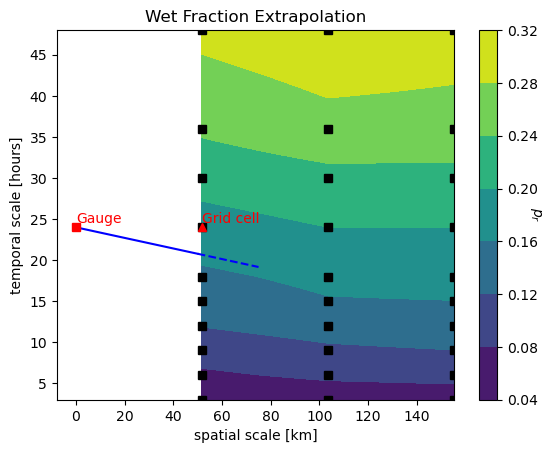

In [12]:
downres['Taylor_contour']

In [15]:
# downres['esa_d'] = (downres['eps_d'])/downres['alp_d']
# downres['esa_s'] = (downres['eps_s'])/downres['alp_s']
# downres['etaC'] = (downres['Cd'] - downres['Cs'])/downres['Cs']
# downres['etaW'] = (downres['Wd'] - downres['Ws'])/downres['Ws']
# downres['etaN'] = (downres['Nd'] - downres['Ns'])/downres['Ns']
# downres['etaGAM'] = (downres['gam_d'] - downres['gam_s'])/downres['gam_s']
# downres['etaESA'] = (downres['esa_d'] - downres['esa_s'])/downres['esa_s']

(204.61332269113174, 0.7494030941231388)

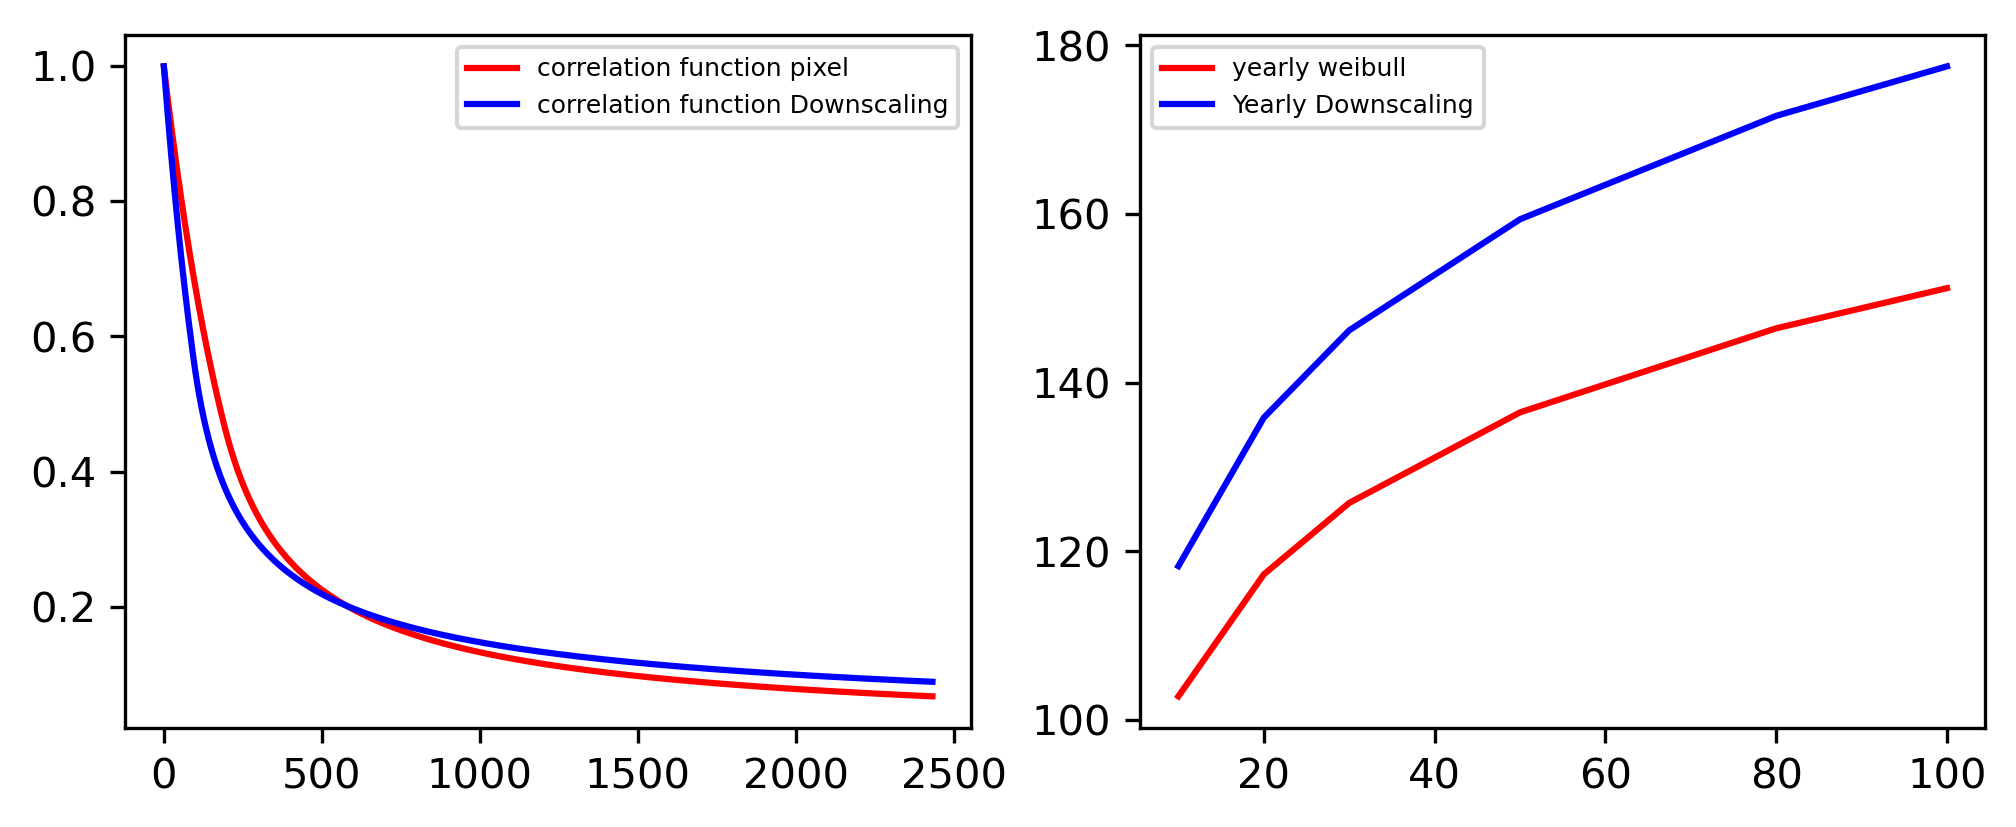

In [24]:
xx = np.arange(2433)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(xx, down.epl_fun(xx, downres['eps_s'], downres['alp_s']), '-r', label='correlation function pixel')
ax1.plot(xx, down.epl_fun(xx, downres['eps_d'], downres['alp_d']), '-b', label='correlation function Downscaling')
plt.legend(fontsize=6)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(downres['Tr'], downres['mev_s'], '-r', label='yearly weibull')
ax1.plot(downres['Tr'], downres['mev_d'], '-b', label='Yearly Downscaling')
plt.legend(fontsize=6)

In [52]:
# test = xr.open_dataset('../output/pixel_stats/tmpa_mev_global_quants.hdf5', engine="h5netcdf",phony_dims='sort') # FOR HDF5
# test

<xarray.Dataset> Size: 1MB
Dimensions:  (phony_dim_0: 4, phony_dim_1: 112, phony_dim_2: 280)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2
Data variables:
    Tr       (phony_dim_0) int32 16B ...
    lat      (phony_dim_1) float32 448B ...
    lon      (phony_dim_2) float32 1kB ...
    qgev     (phony_dim_2, phony_dim_1, phony_dim_0) float32 502kB ...
    qmev     (phony_dim_2, phony_dim_1, phony_dim_0) float32 502kB ...
    thresh   float32 4B ...

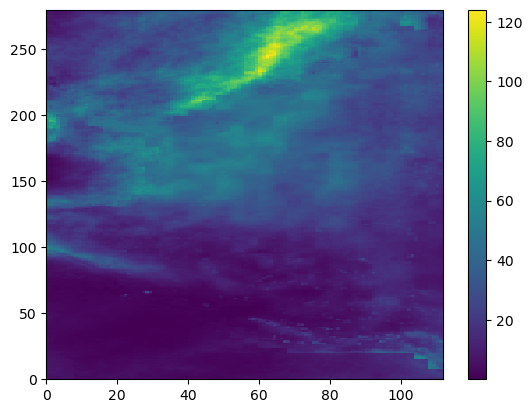

In [75]:
# plt.pcolor(test['qgev'].values[:,:,3])
# plt.colorbar()

In [50]:
# test = xr.open_dataset('../output/pixel_stats/predicted_error_maps.nc')
# test

<xarray.Dataset> Size: 1MB
Dimensions:  (x: 280, y: 112)
Coordinates:
    lon      (x) float32 1kB ...
    lat      (y) float32 448B ...
Dimensions without coordinates: x, y
Data variables:
    etaC     (x, y) float64 251kB ...
    etaW     (x, y) float64 251kB ...
    etaN     (x, y) float64 251kB ...
    etaQ     (x, y) float64 251kB ...